# CNN Language Models

In [62]:
# PREPARE DATA
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# read words from file
#words = open('./english_verbs.txt', 'r').read().splitlines()
# alternative dataset: https://github.com/dwyl/english-words
#words = open('./words_alpha.txt', 'r').read().splitlines()
# alternative dataset: german names
words = open('./names.txt', 'r').read().splitlines()

print(words[:10])

print('num words: ', len(words)) 

# Prepare Alphabet
## count characters 
dataset_characters = []
for word in words:
    word_characters = list(word) 
    dataset_characters.extend(word_characters)
distinct_characters = sorted(list(set(dataset_characters)))
print('len dictinct characters: ', len(distinct_characters))
print('distinct_characters: ', distinct_characters)

special_characters = ['_'] # changed to blank only for convenience reasons

# ngram characters = distinct characters + start token and end token -> + 2
num_characters = len(distinct_characters) + len(special_characters)
print('Num Characters: ', num_characters)

# create a character to index mapping because it is easier to work with indices when using tensor matrices -> every character gets assigned an index
character_to_index_map = {character:index for index, character in enumerate(distinct_characters)}
print(character_to_index_map)

# add our special characters that symbolize start and end of a word
character_to_index_map['_'] = 26
print(character_to_index_map)

# write characters into the cells to make it look more nicely
index_to_character_map = {index:character for character, index in character_to_index_map.items()}
print(index_to_character_map)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
num words:  32033
len dictinct characters:  26
distinct_characters:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Num Characters:  27
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '_': 26}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'

In [63]:
# DATA LOADER
context_length = 16

def build_dataset(words):
    X, Y = [], [] # X = inputs, Y = outputs
    for word in words: # [:4] 
        context = [26] * context_length # _ _ _ word _
        for character in word + '_': 
            index = character_to_index_map[character]
            X.append(context)
            Y.append(index)
            #print(''.join(index_to_character_map[i] for i in context), ' -> ', index_to_character_map[index])
            context = context[1:] + [index] # crop first context token and append current token as the new last one of the context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# SPLIT DATA INTO TRAIN, DEV, TEST -> 80%, 10%, 10%
import random
random.shuffle(words)
train_num = int(0.8*len(words))
dev_num = int(0.9*len(words)) - train_num
test_num = len(words) - (train_num + dev_num)
print(train_num)
print(dev_num)
print(test_num)

X_train, Y_train = build_dataset(words[:train_num])
X_dev, Y_dev = build_dataset(words[train_num:train_num+dev_num])
X_test, Y_test = build_dataset(words[train_num+dev_num:])

# SANITY CHECK: 
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(index_to_character_map[ix.item()] for ix in x), '--->', index_to_character_map[y.item()])

25626
3203
3204
torch.Size([182375, 16]) torch.Size([182375])
torch.Size([22916, 16]) torch.Size([22916])
torch.Size([22855, 16]) torch.Size([22855])
________________ ---> c
_______________c ---> a
______________ca ---> p
_____________cap ---> r
____________capr ---> i
___________capri ---> c
__________capric ---> e
_________caprice ---> _
________________ ---> r
_______________r ---> o
______________ro ---> w
_____________row ---> a
____________rowa ---> n
___________rowan ---> _
________________ ---> k
_______________k ---> i
______________ki ---> n
_____________kin ---> g
____________king ---> s
___________kings ---> t


## WaveNet

A convolutional architecture to fuse embeddings step by step. 

![](https://kim.hfg-karlsruhe.de/wp-content/uploads/2018/01/wavenet.png)

Why wavenet? -> mlp crushes the whole temporal information to fast together -> idea in wavenet is to step by step fuse the steps and aggregate information this way

In [64]:
# Linear Layer/Weight Matrix
class Linear: 
    def __init__(self, input_dim, output_dim, bias=True):
        self.W = torch.randn((input_dim, output_dim))
        self.b = torch.zeros(output_dim) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

In [65]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [66]:
# Embedding Layer -> wrap W (weight matrix) into a class
class Embedding: 
    def __init__(self, vocab_size, embedding_dim):
        self.W = torch.randn((vocab_size, embedding_dim))
        
    def __call__(self, index):
        self.out = self.W[index]
        return self.out

    def parameters(self):
        return [self.W]

In [67]:
# Convolution Layer
class FusionLayer1D: # Conv1D
    def __init__(self, fusion_size):
        self.fusion_size = fusion_size 
        
    def __call__(self, x):
        # get dimensions: batch_size, num_tokens, embedding_dim 
        B, T, C = x.shape
        x = x.view(B, T//self.fusion_size, C*self.fusion_size)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [68]:
# Layer Stacking Class -> in pytorch this is called nn.Sequential => this is just a container class for layers that are applied sequentially
class Sequential: 
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [72]:
# BUILD MODEL
embedding_dim = 10
hidden_dim = 200
vocab_size = num_characters
fusion_size = 2 # -> receptive field size = fusion_size * num fusion layers -> in our example we have a total receiptive field of 8 == our context length

# example: this is how an MLP would look like from last week
mlp_language_model = Sequential([
    Embedding(vocab_size, embedding_dim), 
    FusionLayer1D(fusion_size=context_length),
    Linear(embedding_dim * context_length, hidden_dim, bias=False), 
    Tanh(), 
    Linear(hidden_dim, vocab_size),
])

# WaveNet/CNN Language Model 
cnn_language_model = Sequential([
    Embedding(vocab_size, embedding_dim), 
    # fusion block 1 -> 16 -> 8
    FusionLayer1D(fusion_size=fusion_size),
    Linear(embedding_dim * fusion_size, hidden_dim, bias=False),
    Tanh(), 
    # fusion block 1 -> 8 -> 4
    FusionLayer1D(fusion_size=fusion_size),
    Linear(hidden_dim * fusion_size, hidden_dim, bias=False),
    Tanh(), 
    # fusion block 2 -> 4 -> 2
    FusionLayer1D(fusion_size=fusion_size),
    Linear(hidden_dim * fusion_size, hidden_dim, bias=False), # important: projected into hidden dimension of 200 here per latent token!
    Tanh(), 
    # fusion block 3 -> 2 -> 1
    FusionLayer1D(fusion_size=fusion_size),
    Linear(hidden_dim * fusion_size, hidden_dim, bias=False), # important: last layer squeezes out dimension of 1 -> see unsqueeze in fusion layer
    Tanh(), 
    Linear(hidden_dim, vocab_size) # output layer -> given latent vector of input -> predict probability distribution over vocab
])


# activate gradients for all parameters
parameters = cnn_language_model.parameters()
for p in parameters:
    p.requires_grad = True
    
#parameters = mlp_language_model.parameters()
#for p in parameters:
#    p.requires_grad = True

In [73]:
# TEST MODEL
# take for random examples out of the training set into a batch
random_index = torch.randint(0, X_train.shape[0], (4,)) 
X_batch, Y_batch = X_train[random_index], Y_train[random_index]
logits = mlp_language_model(X_batch)
logits = cnn_language_model(X_batch)
print(X_batch.shape)
print(X_batch)

# print model architecture
print('MLP Language Model: ')  
for layer in mlp_language_model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    
print('-------------------------------------------------')    
    
# print model architecture
print('CNN Language Model: ')  
for layer in cnn_language_model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    
# print logits
print(logits.shape)
print(logits[0])

torch.Size([4, 16])
tensor([[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,  0, 13, 18, 11,  4],
        [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 19, 18,  8, 14],
        [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,  1,  4, 13],
        [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 18,  4]])
MLP Language Model: 
Embedding : (4, 16, 10)
FusionLayer1D : (4, 160)
Linear : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)
-------------------------------------------------
CNN Language Model: 
Embedding : (4, 16, 10)
FusionLayer1D : (4, 8, 20)
Linear : (4, 8, 200)
Tanh : (4, 8, 200)
FusionLayer1D : (4, 4, 400)
Linear : (4, 4, 200)
Tanh : (4, 4, 200)
FusionLayer1D : (4, 2, 400)
Linear : (4, 2, 200)
Tanh : (4, 2, 200)
FusionLayer1D : (4, 400)
Linear : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)
torch.Size([4, 27])
tensor([  4.6138, -13.3292,  18.4963,  -1.4518,   2.1336,   3.3425,   9.4242,
          6.9501,  -3.5200,  -6.5981, -10.1841,  11.5102,  -5.9456,  -2.3177,
         -3.

In [74]:
# TRAIN MODEL

num_epochs = 25000
batch_size = 32
learning_rate = 0.01
lossi = []

for i in range(num_epochs):
    # create minibatch
    random_indices = torch.randint(0, X_train.shape[0], (batch_size,)) 
    X_batch, Y_batch = X_train[random_indices], Y_train[random_indices]
    
    # forward pass
    logits = cnn_language_model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)
    
    # backward pass -> zero out gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights -> simple stochastic gradient descent
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    # logging
    if i % 1000 == 0:
        print(f'{i:7d}/{num_epochs:7d}: {loss.item():.4f}')
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())

      0/  25000: 32.3277
   1000/  25000: 5.7184
   2000/  25000: 3.5692
   3000/  25000: 3.0771
   4000/  25000: 3.2917
   5000/  25000: 3.2688
   6000/  25000: 2.9839
   7000/  25000: 2.6487
   8000/  25000: 2.8461
   9000/  25000: 2.6585
  10000/  25000: 3.0712
  11000/  25000: 2.6775
  12000/  25000: 2.7514
  13000/  25000: 2.5596
  14000/  25000: 2.9278
  15000/  25000: 2.8302
  16000/  25000: 2.6345
  17000/  25000: 2.7054
  18000/  25000: 2.6886
  19000/  25000: 2.6487
  20000/  25000: 2.8147
  21000/  25000: 2.3881
  22000/  25000: 2.6653
  23000/  25000: 2.7134
  24000/  25000: 2.4967


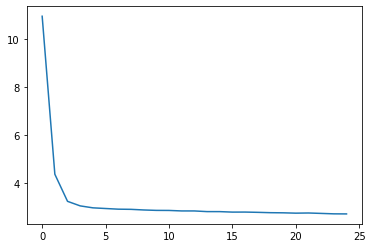

In [75]:
# PLOT training statistics
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [76]:
# EVALUATE MODEL 

# put layers in evaluation mode
for layer in cnn_language_model.layers:
    layer.training = False

@torch.no_grad() # after this decorated gradients are disabled
def split_loss(split, model):
    x, y = {
        'train': (X_train, Y_train), 
        'dev': (X_dev, Y_dev), 
        'test': (X_test, Y_test)
        }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train', cnn_language_model)
split_loss('dev', cnn_language_model)
split_loss('test', cnn_language_model)

train 2.708395004272461
dev 2.7151899337768555
test 2.7115073204040527


In [84]:
# SAMPLING 
num_words_to_sample = 10

for i in range(num_words_to_sample):
    model = cnn_language_model
    out = []
    blank_index = 26 # start with the blank symbol
    context = [blank_index] * context_length 
    while True: 
        # forward pass 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distribution over characters
        index = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift context to the right
        context = context[1:] + [index]
        out.append(index_to_character_map[index])
        if index == 26: 
            break 
    print(''.join(out)) 

lell_
eaeio_
keaz_
aaboma_
mfnnaca_
rnkikn_
nelnnn_
aurraa_
anuaaln_
llinacil_


---

# Model Training

**Pre-Training:**
- Compute Optimal Training -> Chinchilla Paper: https://www.youtube.com/watch?v=TSqkKH4zuZY, https://arxiv.org/abs/2304.03208
- cerebras: https://www.cerebras.net/
- mosaic: https://www.mosaicml.com/

---

**Fine-Tuning:**
- Low-Rank Adaptation
    - PEFT Fine-Tuning
    
    
<img src="https://www.philschmid.de/static/blog/fine-tune-flan-t5-peft/thumbnail.png" alt="Image" width="900" height="900">



- Instruction Fine-Tuning
    - NIv2: https://instructions.apps.allenai.org/
    - Alpaca: https://crfm.stanford.edu/2023/03/13/alpaca.html
    - Koala: https://bair.berkeley.edu/blog/2023/04/03/koala/
    - EvolInstruct: https://github.com/nlpxucan/WizardLM
    - FLAN: https://ai.googleblog.com/2023/02/the-flan-collection-advancing-open.html, https://github.com/lamini-ai/lamini
 
 
- Dialog/Chat Fine-Tuning
    - open assistant: https://huggingface.co/datasets/OpenAssistant/oasst1
    - share gpt: https://github.com/domeccleston/sharegpt
    
 
- Alignment: 
    - Reinforcement Learning From Human Feedback: 
        - anthropic rlhf: https://huggingface.co/datasets/Anthropic/hh-rlhf
        
---

**Model Evaluation:** 
- Metrics:
    - MMLU: https://arxiv.org/abs/2009.03300
    - BIGBench: https://arxiv.org/abs/2206.04615
    - SuperGLUE: https://arxiv.org/abs/1905.00537
- Human Evaluation
    - ChatbotArena: https://arena.lmsys.org/
- Statistical Methods


---


**Iterative Adaptation:**
- LLM Ops Cycle:

<img src="./llm_ops_cycle.png" alt="Image" width="700" height="700">

---

# Questions: 

- Topics of interest for discussion on 26.6.2023 ?
    - societal aspects of LLMs 
    - how to use LLMs ?
    - what to regulate? 
    - LLM cookbook -> how to use LLMs for learning and performance
    
    - strafmündigkeit von KI
        - deepfakes, generated images, 
            - Schuhmacher ChatGPT Simulation: https://www.digitaltrends.com/computing/ai-generated-schumacher-article-leads-to-editors-dismissal/
        - fakenews, desinformation: https://www.tagesschau.de/faktenfinder/ki-desinformation-fakes-101.html
            - mögliche lösungen?
            - wasserzeichen
        - urheberechte? copyrights
            - metal: https://www.youtube.com/watch?v=wnfFAFBsg_4
            - drake fake
        - feeds radikalisieren -> code your own ai
     - regulation?  
  
- Date for presentations (20 min presentation + 3 minute questions)
    - suggestion: 19.6 or 26.6

---